### Reinforcement learning the active learning policy 



In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import src.active_learning as al
import src.viz as viz
import src.reinforcement as rl

import importlib as imp
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.distributions import Categorical
# import pyro

%matplotlib inline

### Get the data:

Get MNIST formatted from PyTorch.

In [2]:
# Get raw datasets 
train_set = dset.MNIST(root='./data', train=True, transform=transforms.ToTensor(),download=False)
test_set = dset.MNIST(root='./data', train=False, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=len(test_set),shuffle=False)

In [3]:
# Get x/y split for the test set 
train_x, train_y, val_x, val_y = al.get_dataset_split(train_set)
test_x,test_y = al.get_xy_split(test_loader)

### Make the models:

Below we make both the logistic regression and the CNN for experiemnts with RL on active learning policies

In [4]:
# Define the logistic regression model
class logreg(nn.Module):
    """ Logistic regression """
    def __init__(self):
        super(logreg, self).__init__()
        self.classes = 10
        self.w = nn.Linear(28*28,self.classes)
        
    def forward(self, x):
        x = self.w(x.view(-1,1,28*28))
        return F.log_softmax(x.view(-1,self.classes),dim=1)

# Define the CNN model 
class CNN(nn.Module):
    """ CNN for MNIST """
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1,1,28,28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

# Make the RL agent to interact with the environment 
class AgentRL(nn.Module):
    def __init__(self, inpt_dim, hidden_dim, num_policies):
        super(AgentRL, self).__init__()
        self.num_policies = num_policies
        self.inner_layer = nn.Linear(inpt_dim, hidden_dim)
        self.outer_layer = nn.Linear(hidden_dim, num_policies)
        self.rewards = []
        self.saved_log_probs = []
        
    def forward(self, x):
        x = x.view(1,-1)
        x = F.relu(self.inner_layer(x))
        x = self.outer_layer(x)
        return F.softmax(x, dim=1)

### RL approach - Policy Gradients (PG)

* Source: http://karpathy.github.io/2016/05/31/rl/

Here I will try the PG appraoch to this problem.

##### Ideas:

* actions are choosing the policy by which we choose the next point. 

* so is the state the performance of the model or the model itself or the parameters?? 

* OR IS THE STATE THE SET OF UNLABELED POINTS?!?!

* State is the set of all training points 

* NO state should be the marginals $p(\mathbf{y}|x_i)$ for real!!!

* could use grad of accuracy to approx reward function. steeper the gradient higher the reward.

### Reinforcement learning:

Here I learn the the reinforcement policy over the different active learning policies.

In [6]:
rl = imp.reload(rl)
al = imp.reload(al)
viz = imp.reload(viz)

mod = logreg()
opt = optim.Adam(mod.parameters(),lr=0.01)
policy_key = {0: 'random', 1: 'boundary', 2: 'max_entropy', 3: 'conf', 4: 'uniform'}
arl = AgentRL(int(len(train_x)*10), 128, 5)
optimizer_rl = optim.Adam(arl.parameters(), lr=1e-2)


rl_e = rl.Environment(mod, train_x, train_y, val_x ,val_y, nn.NLLLoss(), opt)
rl_e.set_params(al_itrs=20, npoints=20, batch_size=10)
pc,ac = rl_e.run_experiments(arl, optimizer_rl, policy_key, n_experiments=10)


  0%|          | 0/10 [00:00<?, ?it/s]
Exception in thread Thread-4:
Traceback (most recent call last):
  File "/Users/paulblankley/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/paulblankley/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/paulblankley/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 10/10 [04:34<00:00, 27.40s/it]


### Visualize:

Visualize the output of the RL agent.

Final accuracy over active learning policy: 0.8303


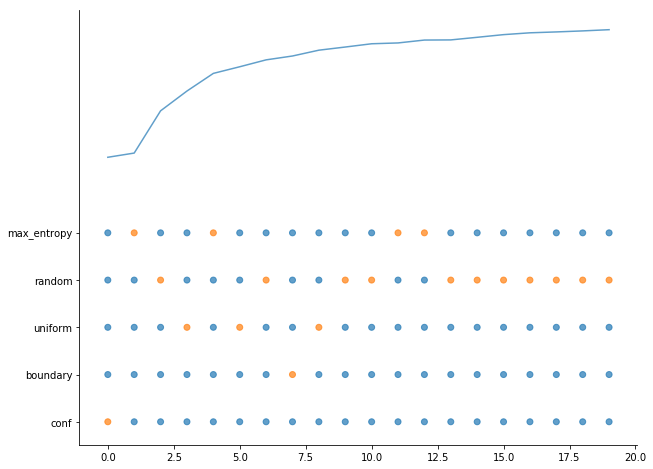

In [13]:
# Visualize the instance given by 'ii'
ii = 0
viz.viz_rl(pc,ac,ii)
print('Final accuracy over active learning policy:',ac[ii][-1][0])
